In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colorbar as cbar
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import h5py
import os
import pickle
from cherab.tools.inversions import ToroidalVoxelGrid, invert_regularised_nnls


plt.rcParams.update({'font.size': 16, "figure.dpi" : 150,
                     'figure.constrained_layout.use': True})

WORKDIR = str(globals()['_dh'][0]) + "/"
print(WORKDIR)
BASEDIR = os.path.realpath(os.path.join(WORKDIR, "../../")) + "/"
SAVEDIR = WORKDIR + "data/"
USE_CAD_MESH = False
# Default location for the voxel grid data
if USE_CAD_MESH:
    VOXEL_PATH = SAVEDIR + "voxel_grid_with_reflections.pickle"
else:
    VOXEL_PATH = SAVEDIR + "voxel_grid.pickle"

SPECTRAL_BINS = 100
SPECTRAL_PARTS = 3

# Load AXUV diode sensitivity data
sensitivity = np.genfromtxt(os.path.join(BASEDIR, "cherab/aug/axuv/axuv_sensitivity.csv"), delimiter=",")
degraded_sensitivity = np.genfromtxt(os.path.join(BASEDIR, "cherab/aug/axuv/degraded_sensitivity.csv"), delimiter=",")

measured_times = ["demo"]
# If one has more timesteps, the time evolution of the measurements can be visualized.
# The plots in this notebook are from one such case.

# just create a dummy time evolution list
times = np.linspace(0, 1, len(measured_times))

# Voxel data handling
def open_voxel_measurements(fname_end):
    "Opens the emiission data generated by voxels_sector_16.py and returns everything from the file."
    fname = "voxel_emissions_" + fname_end + ".h5"
    with h5py.File(SAVEDIR + fname, "r") as file:
        emissions = file["emissions"][()]
        wavelength_bin_widths = file["wavelength_bin_widths"][()]
        denergies = 1239.8 / wavelength_bin_widths  # width of spectral bins in eV
        wavelengths = file["wavelengths"][()]
        energies = file["energies"][()]
        diode_names = file["diode_names"][()]
        diode_measurements = file["diode_measurements"][()]

    return wavelengths, energies, emissions, diode_names, diode_measurements, denergies

def load_voxels(name=VOXEL_PATH):
    """Loads and returns relevant voxel data from the pickle"""
    try:
        with open(name, "rb") as f:
            grid_data = pickle.load(f)
    except FileNotFoundError:
        raise RuntimeError(
            "Geometry data not found: please create the voxels first."
        )

    voxel_grid = ToroidalVoxelGrid(grid_data['voxel_data'])
    grid_laplacian = grid_data['laplacian']
    sensitivity_matrix = grid_data['sensitivity_matrix']
    print("Voxel data loaded.")

    return voxel_grid, grid_laplacian, sensitivity_matrix

# Setting up AXUV sensitivity functions from the sensitivity data
def sensitivity_function(where):
    """
    Manufacturer specified sensitivity function of the AXUV diodes in A/W 

    :param float where: where to sample the sensitivity function in energy [eV]
    """
    return np.interp(where, sensitivity[:, 0], sensitivity[:, 1])

def degraded_sensitivity_function(where):
    """
    Average degraded sensitivity function of the AXUV diodes in A/W 
    from [M. Bernert, Rev. Sci. Instrum., 2014] 

    :param where: where to sample the sensitivity function in energy [eV]
      Can be a list or numpy array or can be float or int
    """
    if isinstance(where, (list, np.ndarray)):
        toreturn = np.zeros(len(where))
        for index, loc in enumerate(where):
            if loc < 89.4308:
                toreturn[index] = np.interp(loc, sensitivity[:, 0], sensitivity[:, 1])
            else:
                toreturn[index] = np.interp(loc, degraded_sensitivity[:, 0], degraded_sensitivity[:, 1])
        return toreturn
    elif isinstance(where, (float, int)):
        if where < 89.4308:
            return np.interp(where, sensitivity[:, 0], sensitivity[:, 1])
        else:
            return np.interp(where, degraded_sensitivity[:, 0], degraded_sensitivity[:, 1])
    else:
        print("Unsupported type passed to degraded_sensitivity_function()")

# static plotting    
def plot_voxel_data(ax, voxels, voxel_values, cmap="inferno", vmin=None, vmax=None, title=None):
    """
    Either only plot the voxel locations if voxel_values is None
    or color the voxels according to voxel_values.
    Useful for plotting emissions and optionally inversions.
    """ 
    patches = []
    for voxel in voxels:
        polygon = Polygon([(v.x, v.y) for v in voxel.vertices], closed=True)
        patches.append(polygon)

    p = PatchCollection(patches, cmap=cmap)
    if voxel_values is None:
        # Plot just the outlines of the grid cells
        p.set_edgecolor('black')
        p.set_facecolor('none')
    else:
        p.set_array(voxel_values)
        vmax = vmax or max(voxel_values)
        vmin = vmin or min(voxel_values)
        p.set_clim([vmin, vmax])

    if ax is None:
        _, ax = plt.subplots()
    ax.add_collection(p)
    ax.set_xlim(voxels.min_radius, voxels.max_radius)
    ax.set_ylim(voxels.min_height, voxels.max_height)
    ax.axis("equal")
    if title is not None:
        ax.set_title(title)
    return ax

# Animation
def plot_init():
    """Initialization function for animating two subfigures"""
    fig = plt.figure(figsize=(4, 8))
    gs = fig.add_gridspec(3, 1, height_ratios=[3.9, 0.1, 1])

    # Create two axes
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[2])

    axlist = [ax1, ax2]
    return fig, axlist

def plot_voxel_radiation(index, axlist, emission_data):
    """
    The function called in each step of the animation function
    Plots emission data in the poloidal cross section from one spectral bin.
    Shows the actual spectral bin with red lines overlayed 
    on the sensitivity function plotted in energy
    """
    print(index, end="\r")
    ax1, ax2 = axlist
    ax1.clear()
    ax2.clear()
    plot_voxel_data(ax=ax1, voxels=voxel_grid, 
                    voxel_values=np.sum(emission_data[10*index:10*index+10, :],
                                        axis=0), title="Emitted radiation by the"
                                        "\nvoxels in one spectral bin")

    ax1.set_facecolor('k')
    ax1.set_xlim(1, 2.2)
    ax1.set_ylim(-1.2, 1)
    ax1.set_xlabel('R')
    ax1.set_ylabel('z')

    ax2.plot(energies, sensitivity_function(energies))
    ax2.axvline(energies[10*index], color="red")
    ax2.axvline(energies[10*index+10], color="red")
    ax2.set_xscale("log")
    ax2.set_xlim(0.9, 5000)
    ax2.grid()
    ax2.set_title("Spectral responsivity")
    ax2.set_xlabel("Photon energy [eV]")
    
    axlist2 = [ax1, ax2]
    return axlist2

def animate_voxel_emissions(timestep):
    """
    This function is the main animation handler, and the reason this script is in a notebook
    One can set this up so that the video is saved with the help of the animation writer in the commented line
    """
    fig, axlist = plot_init()
    print(len(axlist))
    _, _, emissions, _, _, _ = open_voxel_measurements(timestep)

    ani = animation.FuncAnimation(fig, plot_voxel_radiation, init_func=plot_init, 
                                frames=range(29), interval=500, blit=False, fargs=(axlist, emissions))
    # writervideo = animation.FFMpegWriter(fps=5)
    video = ani.to_html5_video()

    return video

# Get the synthetic measurements by applying the spectral sensitivity of the diodes
def get_weighted_power(diode_data, spectrum_energies, degraded=0):
    """
    Spectrally scales the power detected by the AXUV diodes with either the manufacturer-specified
    spectral response function (degraded=0) or with the degraded response function (degraded=1).
    Use the energies array returned by open_voxel_measurements() for :param spectrum_energies:
    """
    weighted_power = np.zeros(diode_data.shape[0])
    for i, energy in enumerate(spectrum_energies):
        try:
            dE_1 = np.abs(energy - spectrum_energies[i-1]) / 2
        except IndexError:
            dE_1 = np.abs(energy - spectrum_energies[i+1]) / 2

        try:
            dE_2 = np.abs(energy - spectrum_energies[i+1]) / 2
        except IndexError:
            dE_2 = np.abs(energy - spectrum_energies[i-1]) / 2

        # since spectrum_energies is decreasing in energy:
        averaging_range = np.linspace(energy+dE_1, energy-dE_2, 100)

        if degraded == 1:
            average_weight = np.average(degraded_sensitivity_function(averaging_range))
        elif degraded == 0:
            average_weight = np.average(sensitivity_function(averaging_range))

        weighted_power[:] += diode_data[:, i] * average_weight

    return weighted_power

# Visualize the time evolution of a range of diode measurements
def time_evolution(diode_first, diode_last, times, measured_times, noise=False, degraded=False):
    """
    Plots the time evolution of the synthetic measurement AXUV diode signals with log normalization.
    Returns the figure, the axis, the pcolormesh object, and the data in a 2D array (diodes by time).
    The user may add Gaussian noise with FWHM=10%
    Either uses the manufacturer specified or the degraded spectral response function.

    NOTE that the user has to specify the first and the last diodes to display,
    for this they have to be familiar with the emission output file or how it was created.
    From sample_voxel_emissions() in voxel_based_emission.py the diodes are appended after each other
    in the order depending on how the cameras have been specified:
    ```
    for camera in cameras:
        for diode in camera.foil_detectors:
            diodename_list.append(diode.name)
    ```
    Otherwise HDFView or the h5py Python library can help to look inside the file.
    """
    numofdiodes = diode_last-diode_first
    diode_data_evolution = np.zeros([numofdiodes, len(measured_times)])
    if noise:
        noise_array = np.random.normal(1.0, 0.1, numofdiodes)
    for i, time in enumerate(measured_times):
        _, energies, _, _, diode_measurements, _ = open_voxel_measurements(time)
        diode_data = diode_measurements[diode_first:diode_last]
        diode_data_evolution[:, i] = get_weighted_power(diode_data, energies, degraded=degraded)
        if noise:
            diode_data_evolution[:, i] *= noise_array

    fig, ax = plt.subplots(figsize=(8,4.5))
    pcm = ax.pcolormesh(times, range(numofdiodes), diode_data_evolution, norm="log", vmin=1e-5, cmap="inferno")
    return fig, ax, pcm, diode_data_evolution

voxel_grid, grid_laplacian, sensitivity_matrix = load_voxels(name=VOXEL_PATH)

wavelengths, energies, emissions, diode_names, diode_measurements, denergies = open_voxel_measurements("demo")


/home/leferi/Code/cherab_aug/demos/AXUV/
Voxel data loaded.


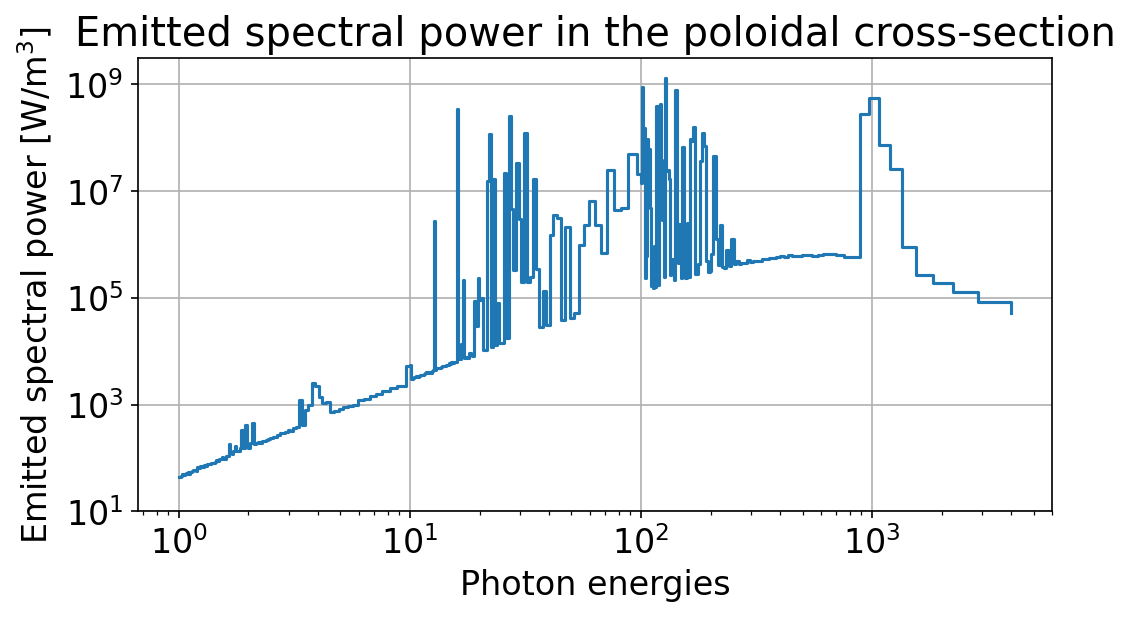

In [2]:
# Emitted spectrum
plt.figure(figsize=(7,4))
plt.step(energies, np.sum(emissions, axis=1))
plt.yscale("log")
plt.xscale("log")
plt.ylim(10, None)
plt.xlabel("Photon energies")
plt.ylabel(r"Emitted spectral power [W/m$^3$]")
plt.title("Emitted spectral power in the poloidal cross-section")
plt.grid()
plt.show()

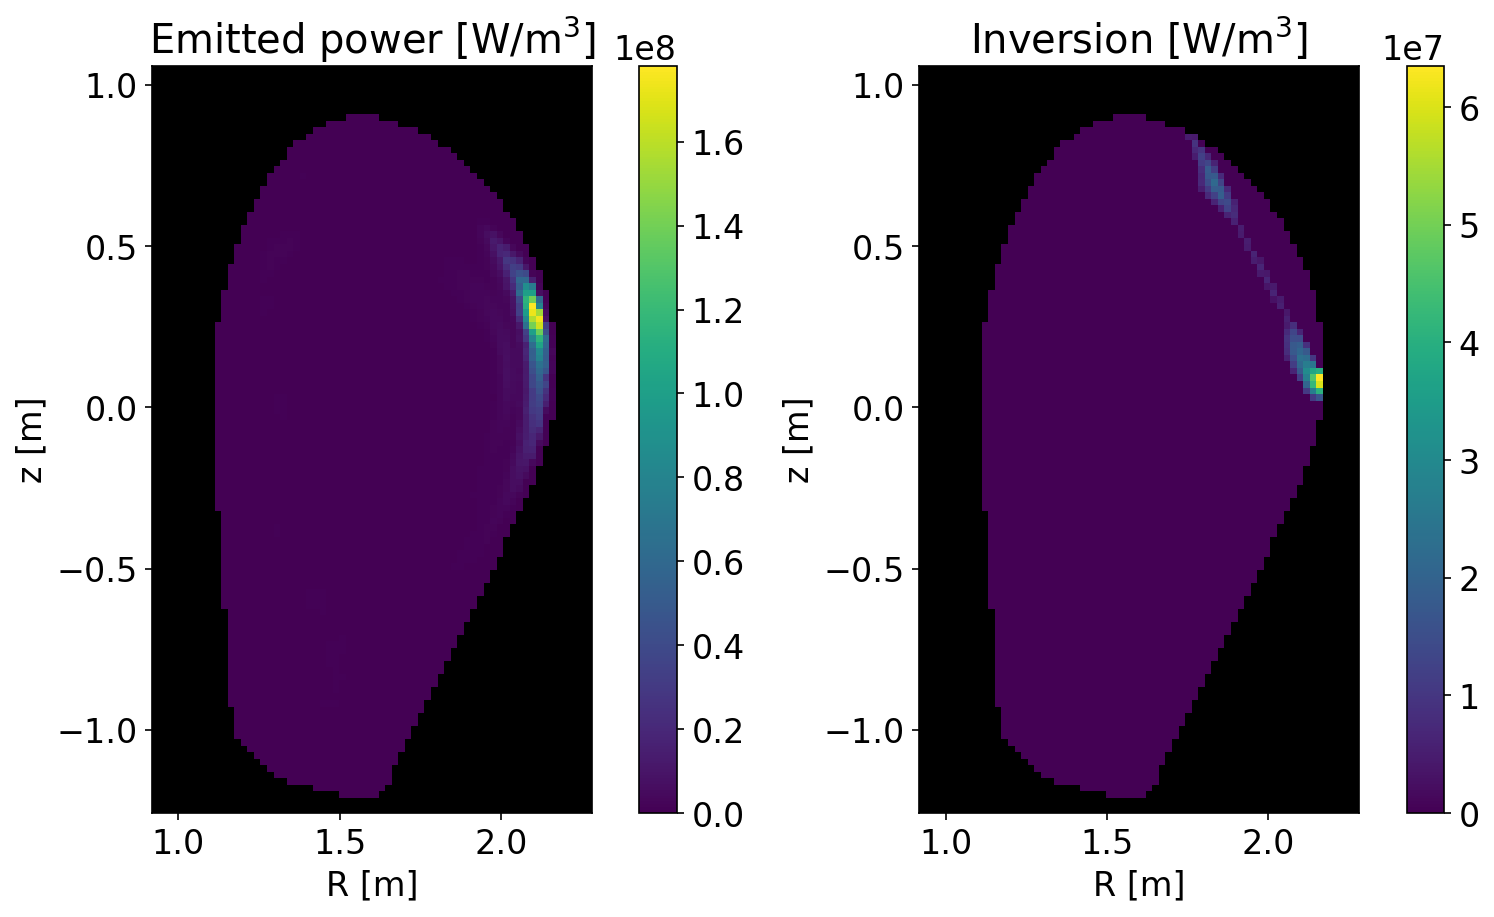

0.0
Phantom total power: 3.736e+07W
Inversion total power: 7.239e+06W


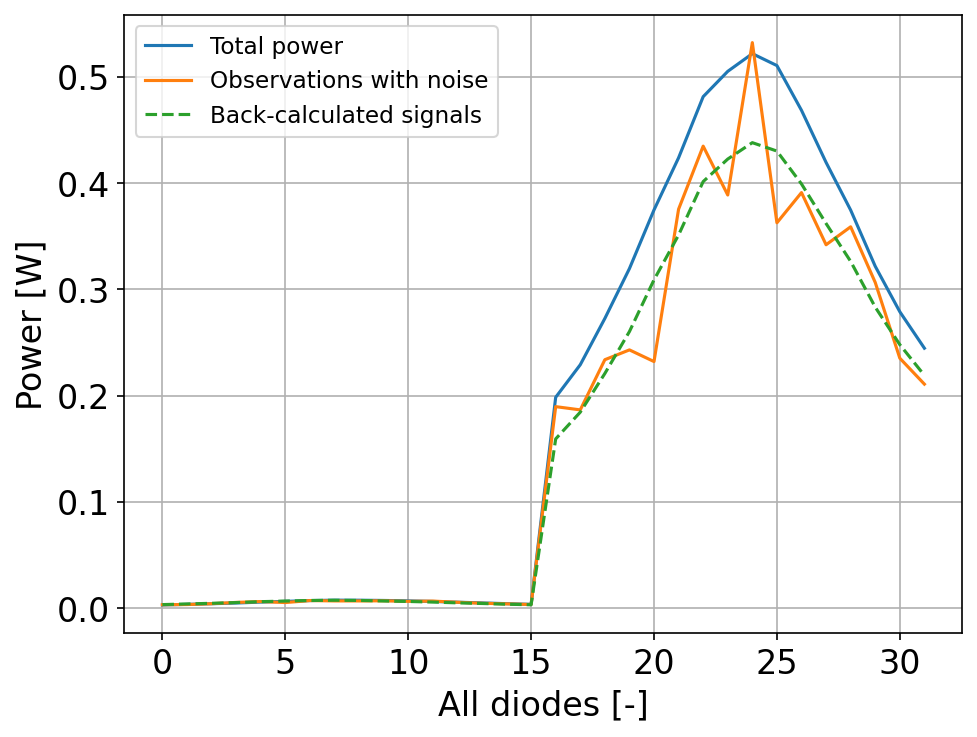

In [7]:
# Inversion example based on the voxel based bolometry inversion example in the Cherab demos
# NOTE In this specific case, due to several factors (mainly the diode properties) the tomographic inversion
# is deemed unreliable during most of the SPI event, so this example is just an example

# ALso the demo only contains 16 LOS per camera when in reality there are 48 LOS per camera
regularization_scaling = 1e-10  # increase to get smoother inversions

for i, mt in enumerate(measured_times):
    _, energies, emissions, _, diode_measurements, _ = open_voxel_measurements(mt)
    phantom_samples = np.sum(emissions, 0)
    plot_inversion = True
    np.random.seed(0)
    multiplier = 1/0.27  # The diodes are supposed to have an average 0.27 A/W response
    # However in reality we know that they have a spectrally changing response function
    noise = np.random.normal(1.0, 0.1, diode_measurements.shape[0])

    observations_weighted = get_weighted_power(diode_measurements, energies, degraded=0) * multiplier
    observations = observations_weighted * noise

    # Perform the inversion
    ################################################################################
    # We'll use a regularised NNLS inversion here: experience shows it performs
    # better than SART for bolometry systems with relatively low numbers of
    # foils (though it does perform well for imaging cameras with high resolution).

    # Apply a large penalty for placing radiation where there is no bolometer
    # coverage, else the algorithm can put radiation there without affecting the
    # measurements
    grid_laplacian[:, np.nonzero(sensitivity_matrix.sum(axis=0) == 0)] = 1e10

    inverted_emission, residual_norm = invert_regularised_nnls(
        sensitivity_matrix, observations, alpha=regularization_scaling,
        tikhonov_matrix=grid_laplacian
    )

    ################################################################################
    # Calculate some metrics for comparison with the phantom
    ################################################################################
    back_calculated_measurements = sensitivity_matrix @ inverted_emission
    phantom_measurements = sensitivity_matrix @ phantom_samples
    cell_volumes = np.fromiter((cell.volume for cell in voxel_grid), 'float')
    total_phantom_power = phantom_samples @ cell_volumes
    total_inversion_power = inverted_emission @ cell_volumes


    ################################################################################
    # Plot the emissivity profile and the inverted profile
    ################################################################################
    phantom_samples = np.sum(emissions, 0)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    voxel_grid.plot(ax=ax1, voxel_values=phantom_samples, title=r"Emitted power [W/m$^3$]", cmap="viridis")
    voxel_grid.plot(ax=ax2, voxel_values=inverted_emission, title=r"Inversion [W/m$^3$]", cmap="viridis")
    ax1.set_xlabel("R [m]")
    ax1.set_ylabel("z [m]")
    ax1.set_facecolor('k')
    ax1.set_xlim(1, 2.2)
    ax1.set_ylim(-1.2, 1)
    ax2.set_xlim(1, 2.2)
    ax2.set_ylim(-1.2, 1)
    ax2.set_facecolor('k')
    ax2.set_xlabel("R [m]")
    ax2.set_ylabel("z [m]")
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(phantom_measurements, linestyle="-", label="Total power")
    ax.plot(observations, linestyle="-", label="Observations with noise")
    ax.plot(back_calculated_measurements, linestyle="--", label="Back-calculated signals")
    ax.set_xlabel("All diodes [-]")
    ax.set_ylabel("Power [W]")
    ax.legend(fontsize="x-small")
    plt.grid()
    print(round(times[i], 1))
    print("Phantom total power: {:.4g}W".format(total_phantom_power))
    print("Inversion total power: {:.4g}W".format(total_inversion_power))
    plt.show()